<a href="https://colab.research.google.com/github/Joocheol/Financial-Engineering/blob/master/Two_versions_of_delta_hedging_version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

In [184]:
S0 = 100
K = 100
T = 30/365
r = 0.00
sig = 0.2


M = 1000
N = 30

dt = T/N
rdt = r*dt
sigsdt = sig * np.sqrt(dt)

In [185]:
np.random.seed(1234)

S = np.empty([M,N+1])
rv = np.random.normal(r*dt,sigsdt,[M,N])

for i in range(M):
    S[i,0] = S0
    for j in range(N):
        S[i,j+1] = S[i,j] * (1+rv[i,j])

In [186]:
S.shape

(1000, 31)

$(\Delta_0 - 0) S_0 + (\Delta_1 - \Delta_0) S_1 + (\Delta_2 - \Delta_1) S_{2} + \cdots + (\Delta_{T-1} - \Delta_{T-2}) S_{T-1}+ (\Delta_{T} - \Delta_{T-1}) S_T$

In [187]:
def bscall(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    
def bsput(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)

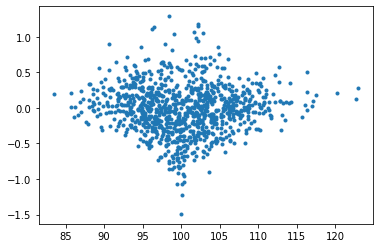

In [191]:
a = []

K = 100

for i in range(M):
    cost = 0
    hedge = 0
    for j in range(N):
        d1 = (np.log(S[i,j]/K)+(r+0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt))
        delta = norm.cdf(d1) - 1
        cost = cost + (delta-hedge) * S[i,j]
        hedge = delta
    
    cost = cost - hedge * S[i,N] + np.maximum(K-S[i,N], 0) - bsput(S0,K,T,r,sig)
    #cost = cost - hedge * S[i,N]
        

    a.append(cost)

plt.plot(S[:,-1], a, marker=".", linestyle='none')
plt.show()

(array([  2.,   5.,  29., 102., 233., 362., 190.,  61.,   8.,   8.]),
 array([-1.49160693, -1.21339729, -0.93518765, -0.656978  , -0.37876836,
        -0.10055872,  0.17765092,  0.45586057,  0.73407021,  1.01227985,
         1.29048949]),
 <a list of 10 Patch objects>)

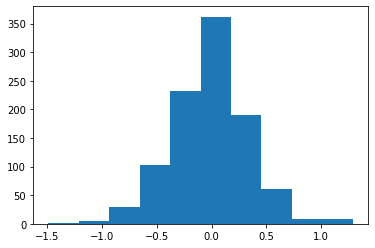

In [192]:
plt.hist(a)

$(\Delta_0 - 0) S_0 + (\Delta_1 - \Delta_0) S_1 + (\Delta_2 - \Delta_1) S_{2} + \cdots + (\Delta_{T-1} - \Delta_{T-2}) S_{T-1}+ (\Delta_{T} - \Delta_{T-1}) S_T$

$\Delta_0 (S_0-S_1) + \Delta_1 (S_1-S_2) + \Delta_2 (S_2-S_3) + \cdots + \Delta_{T-1} (S_{T-1}-S_T) + \Delta_T S_T$

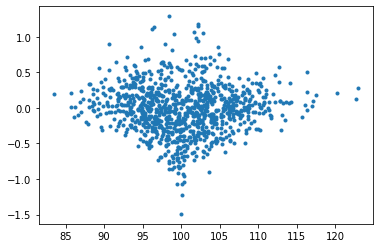

In [193]:
a = []

for i in range(M):
    cost = 0
    price = S[i,0]
    for j in range(N):
        d1 = (np.log(price/K)+(r+0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt))
        delta = norm.cdf(d1)
        cost = cost + delta*(price-S[i,j+1])
        price = S[i,j+1]
    
    cost = cost + np.maximum(S[i,N]-K, 0) - bscall(S0,K,T,r,sig)
        

    a.append(cost)

plt.plot(S[:,-1], a, marker=".", linestyle='none')
plt.show()

In [149]:
import tensorflow as tf

In [233]:
my_input = []

premium = tf.keras.layers.Input(shape=(1,), name="premium")
hedge_cost = tf.keras.layers.Input(shape=(1,), name='hedge_cost')
price = tf.keras.layers.Input(shape=(1,), name="price")

my_input = [premium] + [hedge_cost] + [price]

# premium = tf.keras.layers.Dense(1, activation='linear', trainable=True,
#                 kernel_initializer=tf.keras.initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
#                 bias_initializer=tf.keras.initializers.RandomNormal(0,1))(premium)

for j in range(N):
    
    delta = tf.keras.layers.Dense(32, activation='relu')(price)
    #delta = tf.keras.layers.BatchNormalization()(delta)
    #delta = tf.keras.layers.Dropout(0.5)(delta)
    delta = tf.keras.layers.Dense(32, activation='relu')(delta)
    #delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='relu')(delta)
    delta = tf.keras.layers.Dense(1)(delta)

    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j))
    my_input = my_input + [new_price]


    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="multiply_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])
    price = new_price

cum_cost = hedge_cost

model = tf.keras.Model(inputs=my_input, outputs=cum_cost)

#tf.keras.utils.plot_model(model)

In [234]:
p = bscall(S0,K,T,r,sig) * np.ones([M,1])
c = np.zeros([M,1])
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
x = [p]+[c]+[SS]
y = - np.maximum(S[:,N]-K, 0).reshape(M,1) + p

In [235]:
y.shape

(1000, 1)

In [236]:
model.compile(loss='mse', optimizer='adam')

In [237]:
hist = model.fit(x,y, batch_size=128, epochs=100,  verbose=True)

Epoch 1/100
8/8 [==============================] - 7s 29ms/step - loss: 2502.0754
Epoch 2/100
8/8 [==============================] - 0s 29ms/step - loss: 401.7857
Epoch 3/100
8/8 [==============================] - 0s 27ms/step - loss: 144.1469
Epoch 4/100
8/8 [==============================] - 0s 28ms/step - loss: 61.8466
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 35.1719
Epoch 6/100
8/8 [==============================] - 0s 28ms/step - loss: 21.2760
Epoch 7/100
8/8 [==============================] - 0s 29ms/step - loss: 9.0459
Epoch 8/100
8/8 [==============================] - 0s 30ms/step - loss: 5.5038
Epoch 9/100
8/8 [==============================] - 0s 28ms/step - loss: 4.3915
Epoch 10/100
8/8 [==============================] - 0s 28ms/step - loss: 3.2810
Epoch 11/100
8/8 [==============================] - 0s 30ms/step - loss: 3.0351
Epoch 12/100
8/8 [==============================] - 0s 27ms/step - loss: 2.8728
Epoch 13/100
8/8 [=====================

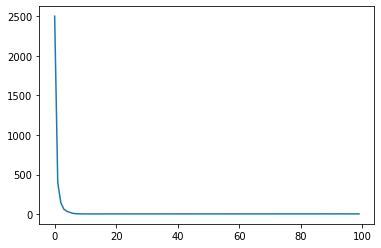

In [238]:
plt.plot(hist.history['loss'])

(array([  2.,   0.,   0.,   4.,   5.,   6.,  19.,  39.,  51.,  74., 116.,
        134., 146., 140., 122.,  77.,  41.,  17.,   6.,   1.]),
 array([-16.15748   , -14.841617  , -13.525754  , -12.20989   ,
        -10.894027  ,  -9.578163  ,  -8.2623005 ,  -6.946437  ,
         -5.6305737 ,  -4.31471   ,  -2.998847  ,  -1.6829836 ,
         -0.36712036,   0.948743  ,   2.2646062 ,   3.5804696 ,
          4.8963327 ,   6.2121964 ,   7.5280595 ,   8.843923  ,
         10.159786  ], dtype=float32),
 <a list of 20 Patch objects>)

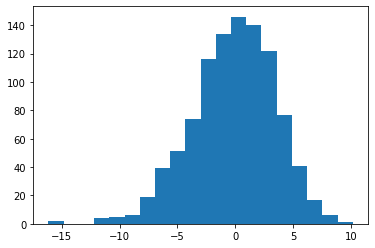

In [239]:
plt.hist(model.predict(x), bins=20)